In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import spacy

2023-05-04 15:48:02.184657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 15:48:02.303521: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-04 15:48:02.805447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-04 15:48:02.805503: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
# !python3 -m spacy download fr_core_news_sm
spacy.load("fr_core_news_sm")

In [3]:
nlp = spacy.load("fr_core_news_sm")
from nltk.corpus import stopwords
from nltk import download
download("stopwords")
stopWords = set(stopwords.words("french"))
print(stopWords)

{'te', 'ses', 'j', 'son', 'ait', 'n', 'on', 'étée', 'seraient', 'avons', 'auraient', 'suis', 'fut', 'es', 'ton', 'sommes', 'ma', 'ce', 'avez', 'fûtes', 'pour', 'aurez', 'auras', 'ayantes', 'étées', 'dans', 'fûmes', 'd', 'le', 'ta', 'étaient', 'avions', 'elle', 'une', 'eussent', 'eût', 'ne', 'furent', 'ayants', 'sur', 'nos', 'eus', 'en', 'sois', 'était', 'soyons', 'soit', 'm', 'ayez', 'seront', 'étante', 'y', 'eu', 'étiez', 'eux', 'étions', 'eusses', 'lui', 'êtes', 'tu', 'vous', 'été', 'il', 'eurent', 'que', 'notre', 'avaient', 's', 'soyez', 'seras', 'serais', 'aurons', 'même', 'étants', 'eue', 'au', 'la', 'me', 'sera', 'de', 'sa', 'ou', 'eut', 'serons', 'serions', 'eussions', 'c', 'ayons', 'aurai', 'votre', 'aies', 'fus', 'avais', 'fût', 'aie', 'serez', 'aura', 'du', 'qui', 'ont', 'sont', 'étais', 'je', 'eussiez', 'des', 'est', 'et', 'un', 'étés', 'aurais', 'eûmes', 'auront', 'seriez', 'fussions', 'nous', 'eusse', 'se', 'ces', 'fussiez', 'toi', 'tes', 'as', 'eûtes', 'soient', 'eues', '

[nltk_data] Downloading package stopwords to /home/fabien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Premières Méthodes

## Chargement des Données

In [4]:
# Données d'entrainement
train_data_complete = pd.read_csv("../data/allocine_genres_train.csv", sep=",")
train_data = train_data_complete[["titre", "synopsis", "genre"]]

## Pré-traitement des Données (Equilibrage des classes)

In [5]:
import string

def preprocess(sentence) :
    list_w = nlp(sentence)
    list_w_clean = []
    res = []
    for token in list_w:
        if (token.text.lower() not in stopWords) and (token.text not in string.punctuation):
            list_w_clean.append(token)
    for token in list_w_clean:
        res.append(token.lemma_.lower())
    return " ".join(res)

In [6]:
X = train_data.drop('genre', axis=1)
y = train_data['genre']

# Initialize the RandomOverSampler
ros = RandomOverSampler()
#ros = RandomUnderSampler()

X["titre"] = X["titre"].apply(preprocess)
X["synopsis"] = X["synopsis"].apply(preprocess)

# Perform oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Convert the resampled data back to a DataFrame
train_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='genre')], axis=1)

## Pré-Traitement des Données (Pipeline statistique)

Comme vu précédemment, les paramètres que nous souhaitons utiliser (*titre*, *synopsis*, *genre*) ne comportent **pas de valeurs manquantes** donc nous n'avons pas besoin d'éliminer d'individus des données d'entrainement.

Nous remarquons aussi que **les données sont déjà tokénisées**. Tous les tokens sont séparés par des espaces.

Cependant, nous pouvons utiliser un transformer pour obtenir des informations statistiques concernant le *synopsis*.

**Remarque:** On normalise ces informations statistiques afin qu'elles aient toutes le même poids lors de la classification.

In [7]:
import string
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.fr.stop_words import STOP_WORDS as en_stop

from sklearn.feature_extraction.text import TfidfVectorizer

def transform_into_token_list(synopsis):
    return synopsis.split(" ")

# Vectorisation des titres
title_stopwords = list(fr_stop) + list(en_stop) + list(string.punctuation)
titre_vectorizer = TfidfVectorizer(tokenizer=transform_into_token_list, 
                                   lowercase=True, 
                                   stop_words=title_stopwords, 
                                   min_df=0.01)

# Vectorisation des synopsis
synopsis_stopwords = list(fr_stop) + list(string.punctuation)
synopsis_vectorizer = TfidfVectorizer(tokenizer=transform_into_token_list, 
                                      lowercase=True, 
                                      stop_words=synopsis_stopwords, 
                                      min_df=0.01)

In [8]:
synopsis_stopwords[:15]

['ceci',
 'ait',
 'quinze',
 'pourquoi',
 'doivent',
 'lorsque',
 'avons',
 'seraient',
 'différentes',
 'seules',
 'compris',
 'jusque',
 'debout',
 'néanmoins',
 'attendu']

En tant qu'humain, certains stop words nous semblent importants...

In [9]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

# Source: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer.html
def text_stats(descriptions):
    return [{"length": len(text), "num_sentences": text.count(".")} for text in descriptions]

text_stats_transformer = FunctionTransformer(text_stats)
text_stats_vectorizer = DictVectorizer(sparse=False)

# Exemple d'utilisation sur les premiers synopsis
res_dict = text_stats_transformer.transform(train_data.synopsis.head())
res_stats = text_stats_vectorizer.fit_transform(res_dict)
print("Input descriptions")
print(train_data.synopsis.head())
print("Output statistics")
stats = pd.DataFrame(res_stats, columns=text_stats_vectorizer.get_feature_names())
print(stats)

min_max_scaler = MinMaxScaler()
scaled_stats = min_max_scaler.fit_transform(res_stats)

print("Before MinMax scaling")
print(res_stats)
print("After MinMax scaling")
print(scaled_stats)

Input descriptions
0    visite istanbul célèbre détectiv belge hercule...
1    jeune homme origine modeste accuser meurtre pè...
2    lorsque marie-laure mère quatre jeune enfant a...
3    vagabond ’ éprendre ’ belle jeune vendeur fleu...
4    histoire vrai carl brashear premier afro améri...
Name: synopsis, dtype: object
Output statistics
   length  num_sentences
0   522.0            1.0
1   334.0            0.0
2   358.0            0.0
3   163.0            3.0
4   250.0            0.0
Before MinMax scaling
[[522.   1.]
 [334.   0.]
 [358.   0.]
 [163.   3.]
 [250.   0.]]
After MinMax scaling
[[1.         0.33333333]
 [0.47632312 0.        ]
 [0.54317549 0.        ]
 [0.         1.        ]
 [0.24233983 0.        ]]


/home/fabien/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


L'utilisation de *MinMaxScaler* permet de ne pas donner plus de poids à l'une des valeurs obtenues, ce qui pourrait affecter la classification.

On peut créer une *Pipeline* qui effectue l'ensemble des transformation sur le jeu de données.

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

column_trans = ColumnTransformer(
    [
        # Titre: tf-idf
        ("titre_tfidf", titre_vectorizer, "titre"),
        # Synopsis: tf-idf
        ("synopsis_tfidf", synopsis_vectorizer, "synopsis"),
        # Synopsis: statistiques
        (
            "synopsis_stats",
            Pipeline(
                [
                    ("text_stats", text_stats_transformer),
                    ("vect", text_stats_vectorizer),
                    ("scaling", min_max_scaler)
                ]
            ), 
            "synopsis"
        )
    ],
    # Others
    remainder="passthrough"
)

In [11]:
column_trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('titre_tfidf',
                                 TfidfVectorizer(min_df=0.01,
                                                 stop_words=['ceci', 'ait',
                                                             'quinze',
                                                             'pourquoi',
                                                             'doivent',
                                                             'lorsque', 'avons',
                                                             'seraient',
                                                             'différentes',
                                                             'seules',
                                                             'compris',
                                                             'jusque', 'debout',
                                                             'néanmoins',
                           

## Création des Jeux d'Entrainement et de Test

Afin de ne pas biaiser le résultat de nos recherches nous n'utiliserons le fichier *allocine_genres_test.csv* uniquement lorsque nous aurons définitivement choisit le classifier. Nous n'utiliserons donc pas *test_data_complete* et *test_data* dans cette section.

Afin de tester et évaluer différents algorithmes nous devons donc créer des jeux de données d'entrainement et de test issus des données d'entrainement (*train_data*). Pour cela nous utilisons la fonction *train_test_split* de la librairie **scikit-learn** en choisissant 20% des données pour créer le jeu de test en prenant soin de mélanger les données (cela perment d'éviter tout biais d'apprentissage: entrainer le classifier unioquement sur les films du XXème siècle).

Nous obtenons donc 4 jeux de données:
- X_train: Titre et synopsis pour entrainement  
- y_train: Genre pour entrainement (label)  
- X_test: Titre et synopsis pour test  
- y_test: Genre pour test (label)  

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data[["titre", "synopsis"]],
                                                    train_data[["genre"]],
                                                    test_size=0.2,
                                                    random_state=12, # Random seed for shuffle
                                                    shuffle=True)

## Apprentissage

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# Pipeline pré-traitement et apprentissage
classifier_pipeline = make_pipeline(
    # Préparation des données pour l'apprentissage
    column_trans,
    # Algorithme d'apprentissage
    LogisticRegression()
)

In [14]:
# Apprentissage avec les données d'entraînement
classifier_pipeline.fit(X_train, y_train.to_numpy())

/home/fabien/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('titre_tfidf',
                                                  TfidfVectorizer(min_df=0.01,
                                                                  stop_words=['ceci',
                                                                              'ait',
                                                                              'quinze',
                                                                              'pourquoi',
                                                                              'doivent',
                                                                              'lorsque',
                                                                              'avons',
                                                                              'seraient',
                                                      

Comme pour le pré-traitement des données, on peut créer une *pipeline* qui regroupe les actions nécessaire à l'apprentissage (pré-traitement et apprentissage).

In [15]:
from sklearn.metrics import classification_report

y_pred = classifier_pipeline.predict(X_test)
print("Classification report:\n\n{}".format(classification_report(y_test, y_pred)))

Classification report:

                 precision    recall  f1-score   support

         biopic       0.76      0.70      0.73       118
        comédie       0.49      0.43      0.46       106
   documentaire       0.73      0.87      0.80        92
          drame       0.47      0.43      0.45       110
     historique       0.70      0.79      0.74        80
        horreur       0.66      0.72      0.69        89
       policier       0.66      0.71      0.68        96
        romance       0.57      0.54      0.55       103
science fiction       0.82      0.78      0.80       108

       accuracy                           0.66       902
      macro avg       0.65      0.66      0.66       902
   weighted avg       0.65      0.66      0.65       902



La précision du classifier est proche de 0.5, ce qui est plutôt faible.

In [16]:
from sklearn.metrics import confusion_matrix

# Liste des labels (classes) se trouvant dans les données de test
labels = np.unique(y_test)
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=labels)
# Matrice de confusion sous forme de DataFrame
confusion_df = pd.DataFrame(cm, index=labels, columns=labels)
print("confusion matrix\n")
print("(row=expected, col=predicted)")
confusion_df.head(n=15)

confusion matrix

(row=expected, col=predicted)


,biopic,comédie,documentaire,drame,historique,horreur,policier,romance,science fiction
biopic,83,2,7,8,7,2,8,0,1
comédie,4,46,6,13,3,4,12,16,2
documentaire,4,3,80,0,0,2,0,1,2
drame,6,12,8,47,4,5,6,22,0
historique,2,1,0,6,63,2,0,3,3
horreur,1,5,3,3,2,64,3,0,8
policier,2,8,0,7,5,3,68,1,2
romance,6,13,5,15,3,3,2,56,0
science fiction,1,3,0,1,3,12,4,0,84


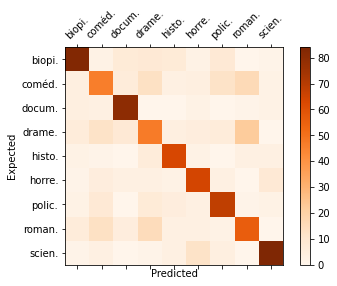

In [17]:
fig = plt.figure() 
ax = fig.add_subplot(111) 
cax = ax.matshow(cm, interpolation="nearest", cmap=plt.cm.Oranges) 
fig.colorbar(cax) 
tick_marks = np.arange(len(labels))
labels_for_fig = [l[0:5]+"." for l in labels]
plt.xticks(tick_marks, labels_for_fig, rotation=45)
plt.yticks(tick_marks, labels_for_fig) 
plt.xlabel("Predicted") 
plt.ylabel("Expected") 
plt.show()

La matrice de confusion permet de mieux comprendre les résultats.

On remarque que le classifieur se trompe plus sur les données qui sont peu représentées dans le jeu de données (*biopic*, *documentaire*, *histoire*).

In [18]:
confusion_df.loc["biopic"].sort_values(ascending=False)

biopic             83
drame               8
policier            8
documentaire        7
historique          7
comédie             2
horreur             2
science fiction     1
romance             0
Name: biopic, dtype: int64

In [19]:
from sklearn import model_selection
folds = 5

stratkfold = model_selection.StratifiedKFold(n_splits=folds, shuffle=True, random_state=12)
y_stratkfold_pred = model_selection.cross_val_predict(classifier_pipeline, X_train, y_train.values.flatten(), cv=stratkfold, n_jobs=-1)

In [20]:
print(classification_report(y_train, y_stratkfold_pred))

                 precision    recall  f1-score   support

         biopic       0.68      0.63      0.65       383
        comédie       0.50      0.48      0.49       395
   documentaire       0.73      0.87      0.80       409
          drame       0.40      0.34      0.37       391
     historique       0.72      0.72      0.72       421
        horreur       0.57      0.60      0.59       412
       policier       0.64      0.67      0.66       405
        romance       0.53      0.51      0.52       398
science fiction       0.71      0.69      0.70       393

       accuracy                           0.62      3607
      macro avg       0.61      0.61      0.61      3607
   weighted avg       0.61      0.62      0.61      3607



En utilisant une méthode de validation croisée qui conserve la proportion des classes dans les plis nous obtenons des résultats du même ordre (précision entre 0.4 et 0.5).

## Comparaison des Différents Algorithmes

Baseline
                 precision    recall  f1-score   support

         biopic       0.00      0.00      0.00       383
        comédie       0.00      0.00      0.00       395
   documentaire       0.00      0.00      0.00       409
          drame       0.00      0.00      0.00       391
     historique       0.12      1.00      0.21       421
        horreur       0.00      0.00      0.00       412
       policier       0.00      0.00      0.00       405
        romance       0.00      0.00      0.00       398
science fiction       0.00      0.00      0.00       393

       accuracy                           0.12      3607
      macro avg       0.01      0.11      0.02      3607
   weighted avg       0.01      0.12      0.02      3607



/home/fabien/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fabien/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fabien/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mutinomial NB
                 precision    recall  f1-score   support

         biopic       0.65      0.55      0.60       383
        comédie       0.46      0.50      0.48       395
   documentaire       0.73      0.82      0.77       409
          drame       0.44      0.32      0.37       391
     historique       0.65      0.68      0.67       421
        horreur       0.52      0.56      0.54       412
       policier       0.63      0.64      0.64       405
        romance       0.48      0.52      0.49       398
science fiction       0.70      0.68      0.69       393

       accuracy                           0.59      3607
      macro avg       0.59      0.59      0.58      3607
   weighted avg       0.59      0.59      0.59      3607

CART
                 precision    recall  f1-score   support

         biopic       0.70      0.78      0.74       383
        comédie       0.31      0.27      0.29       395
   documentaire       0.81      0.90      0.85       409
        

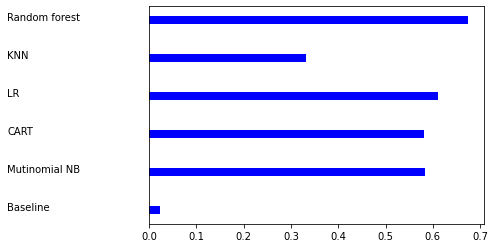

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

# Liste des modèles testés
models = [
    ("Baseline", DummyClassifier(strategy="most_frequent")),
    ("Mutinomial NB", MultinomialNB()),
    ("CART", DecisionTreeClassifier()),
    ("LR", LogisticRegression(max_iter=200)),
    ("KNN", KNeighborsClassifier()),
    ("Random forest", RandomForestClassifier())
]

# Evaluation de chaque résultat l'un après l'autre
scores = []
names = []
scoring = "macro F1"
# Validation croisée à 5 plis
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
# Itération sur les modèles
for name, model in models:
    # Ajout du nom du modèle à la liste name
    names.append(name)
    # Création de la pipeline pour le modèle
    model_pipeline = make_pipeline(column_trans, model)
    # Validation croisée
    y_pred = model_selection.cross_val_predict(model_pipeline, X_train, y_train.values.flatten(), cv=kfold)
    print(name)
    print(classification_report(y_train, y_pred))
    f1 = f1_score(y_train, y_pred, average="macro")
    scores.append(f1)

# Représentation graphique des résultats
indices = np.arange(len(scores))
fig = plt.figure()
plt.barh(indices, scores, .2, label="score", color="b")
plt.yticks(())
for i, c in zip(indices, names):
    plt.text(-.3, i, c)
plt.show()